In [1]:
#Import packages
import pandas as pd
import numpy as np
import scipy
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sklearn.metrics import r2_score
from lmfit import Model

In [2]:
file = input('Data file(including extension): ')

Data file(including extension): Dissociation data.csv


In [3]:
#Read the data file
df = pd.read_csv(file)
df

,Unnamed: 0,T,2e-3nM,2e-2nM,2e-1nM,2nM,2e1nM,2e2nM,2e3nM
0,3006,240.64,0.07935,0.13274,3.85532,24.8685,57.0915,75.4663,93.1211
1,3007,240.74,0.05280,0.20930,3.81783,24.8810,57.0751,75.1319,88.6467
2,3008,240.84,0.08794,0.14446,3.80923,24.9005,57.0219,74.9647,86.6342
3,3009,240.94,0.07858,0.17258,3.77954,24.9084,56.9774,74.9756,85.7443
4,3010,241.04,0.11295,0.18977,3.71392,24.9521,56.9751,74.8186,84.9693
...,...,...,...,...,...,...,...,...,...
8990,11996,1139.64,0.16920,0.39133,3.59751,21.9006,44.5719,51.5545,52.9342
8991,11997,1139.74,0.17076,0.41789,3.59986,21.9076,44.5594,51.5772,52.9264
8992,11998,1139.84,0.16609,0.42180,3.57644,21.8967,44.5407,51.6006,52.9264
8993,11999,1139.94,0.17311,0.40540,3.59283,21.8849,44.5524,51.6006,52.9295


In [4]:
#Define model function
def func(x, bmax, koff, shift):
    return bmax*np.exp(-koff*(x-shift))

In [5]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)

In [6]:
def generate_Initial_Parameters():
    
    parameterBounds = []
    parameterBounds.append([0.0, 100.0]) # search bounds for a
    parameterBounds.append([0.0, 10.0]) # search bounds for koff_1
    
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=2)
    return result.x

In [7]:
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600

In [8]:
column = input('Column to be analysed: ')

Column to be analysed: 2e-2nM


In [17]:
#define variables
xData = df.loc[:, 'T']
yData = df.loc[:, column]
shift = df.loc[0, 'T']
upperbounds = max(df.loc[:, column]) + 0.05*max(df.loc[:, column])

In [18]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)

In [19]:
def generate_Initial_Parameters():
    
    parameterBounds = []
    parameterBounds.append([0.0, 100.0]) # search bounds for bmax
    parameterBounds.append([0.0, 1.0]) # search bounds for koff
    parameterBounds.append([0.0, 1e3]) # search bounds for shift
    
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=2)
    return result.x

In [20]:
# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters = generate_Initial_Parameters()

In [22]:
# now call curve_fit without passing bounds from the genetic algorithm,
# just in case the best fit parameters are aoutside those bounds
fittedParameters, pcov = curve_fit(lambda x, bmax, koff: func(x, bmax, koff, shift), xData, yData, bounds = ([0.0, 0.0], [upperbounds, 10.0]), method = 'dogbox')
print('Fitted parameters:', fittedParameters)
koff = fittedParameters[1]

Fitted parameters: [0.37826461 0.        ]


In [23]:
modelPredictions = func(xData, fittedParameters[0], fittedParameters[1], shift)
absError = modelPredictions - yData
SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

RMSE: 0.07754903312327371
R-squared: 1.3100631690576847e-14


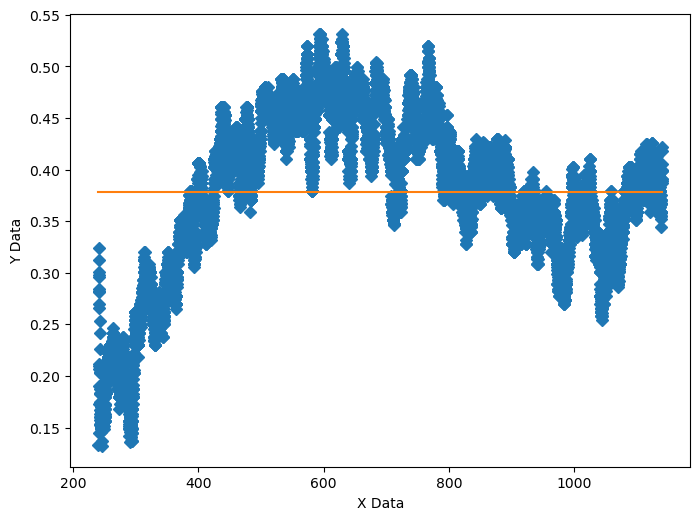

In [24]:
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, fittedParameters[0], fittedParameters[1], shift)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [25]:
print('koff value of concentration', column, 'is', koff)

koff value of concentration 2e-2nM is 0.0
